In [4]:
import matplotlib.pyplot as plt
import json
import glob
import re
import pandas as pd
import numpy as np

In [5]:
def create_regimes(lower, upper, num_divisions, name):
    """Create evenly spaced regimes between lower and upper bounds"""
    edges = np.linspace(lower, upper, num_divisions + 1)
    return [
        {
            "name": f"{name}_{i}",
            "lower": edges[i],
            "upper": edges[i + 1]
        }
        for i in range(num_divisions)
    ]

# Define number of divisions for each parameter
N_AMP_DIVISIONS = 6
N_WD_DIVISIONS = 5

# Create regimes with evenly spaced divisions
AMP_REGIMES = create_regimes(8, 24, N_AMP_DIVISIONS, "amp")
WD_REGIMES = create_regimes(0.0028, 0.0045, N_WD_DIVISIONS, "wd")

t_tot_list = np.linspace(50, 120, 29)

# Get all JSON files matching the pattern
files = glob.glob("json_files/nevergrad_optimized_ef_X_*.json")

# Initialize list to store all results
results = []

for file in files:
    # Extract indices from filename using regex
    match = re.search(r'ef_X_(\d+\.\d+)_amp_(\d+)_wd_(\d+)', file)
    if match:
        t_tot, amp_idx, wd_idx = match.groups()
        
        # Load JSON data
        with open(file, 'r') as f:
            data = json.load(f)
            
        row = {
            't_tot_center': data['t_tot_center'],
            'best_t_tot': data['best_t_tot'],
            'best_amp': data['best_amp'],
            'best_w_d': data['best_w_d'],
            'best_value': data['best_value'],
            'amp_idx': int(amp_idx),
            'wd_idx': int(wd_idx),
            # Add bounds information if needed
            'amp_lower': AMP_REGIMES[int(amp_idx)]['lower'],
            'amp_upper': AMP_REGIMES[int(amp_idx)]['upper'],
            'w_d_lower': WD_REGIMES[int(wd_idx)]['lower'],
            'w_d_upper': WD_REGIMES[int(wd_idx)]['upper'],
            't_tot_lower': data['t_tot_center'] - 1.25,
            't_tot_upper': data['t_tot_center'] + 1.25,
        }
        
        results.append(row)

# Convert to pandas DataFrame
df = pd.DataFrame(results)

# # Sort by optimization value to see best results
# print(df.sort_values('best_value').head())

# Create a pivot table to see patterns
pivot = df.pivot_table(
    values='best_value',
    index=['amp_idx', 'wd_idx'],
    aggfunc='min'
)
# print("\nBest values by amp_idx and wd_idx:")
# print(pivot)

# Save to CSV
df.to_csv("optimization_results_summary.csv", index=False)


Showing 870 points out of 870 total points


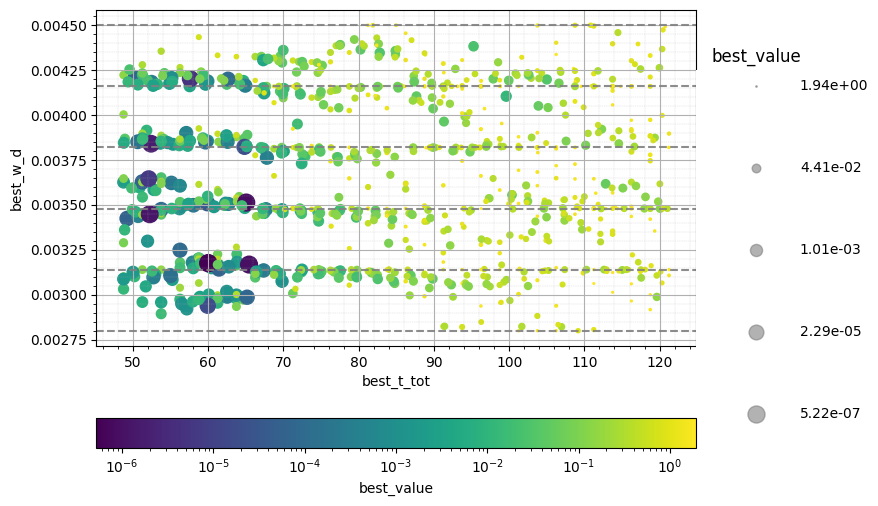

In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm, Normalize

# Create dropdown options for filtering and axis selection
column_options = list(df.columns)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Available colormaps
colormap_options = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'rainbow']
marker_options = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', '+', 'x']

# Create widgets
x_axis_dropdown = widgets.Dropdown(
    options=column_options,
    description='X-axis:',
    value='t_tot_center'
)

y_axis_dropdown = widgets.Dropdown(
    options=numeric_columns,
    description='Y-axis:',
    value='best_value'
)

color_var_dropdown = widgets.Dropdown(
    options=numeric_columns,
    description='Color by:',
    value='wd_idx'
)

size_var_dropdown = widgets.Dropdown(
    options=numeric_columns,
    description='Size by:',
    value='amp_idx'
)

colormap_dropdown = widgets.Dropdown(
    options=colormap_options,
    description='Colormap:',
    value='viridis'
)

marker_dropdown = widgets.Dropdown(
    options=marker_options,
    description='Marker:',
    value='o'
)

size_range_slider = widgets.FloatRangeSlider(
    value=[4, 200],
    min=1,
    max=500,
    step=10,
    description='Size range:',
    continuous_update=False
)

log_scale = widgets.Checkbox(
    value=True,
    description='Log scale y-axis'
)

invert_size = widgets.Checkbox(
    value=False,
    description='Invert size mapping'
)

# Add filter widgets
amp_idx_range = widgets.IntRangeSlider(
    value=[0, N_AMP_DIVISIONS-1],
    min=0,
    max=N_AMP_DIVISIONS-1,
    step=1,
    description='amp_idx range:',
    continuous_update=False
)

amp_idx_single = widgets.IntSlider(
    value=-1,  # -1 means disabled
    min=-1,
    max=N_AMP_DIVISIONS-1,
    step=1,
    description='amp_idx:',
    continuous_update=False
)

wd_idx_range = widgets.IntRangeSlider(
    value=[0, N_WD_DIVISIONS-1],
    min=0,
    max=N_WD_DIVISIONS-1,
    step=1,
    description='wd_idx range:',
    continuous_update=False
)

wd_idx_single = widgets.IntSlider(
    value=-1,  # -1 means disabled
    min=-1,
    max=N_WD_DIVISIONS-1,
    step=1,
    description='wd_idx:',
    continuous_update=False
)

t_tot_range = widgets.FloatRangeSlider(
    value=[df['t_tot_center'].min(), df['t_tot_center'].max()],
    min=df['t_tot_center'].min(),
    max=df['t_tot_center'].max(),
    step=1.0,
    description='t_tot range:',
    continuous_update=False
)

t_tot_values = np.sort(df['t_tot_center'].unique())
t_tot_center_step = t_tot_values[1] - t_tot_values[0]
t_tot_single = widgets.FloatSlider(
    value=t_tot_values[0] - t_tot_center_step,  # min-1 means disabled
    min=t_tot_values[0] - t_tot_center_step,
    max=t_tot_values[-1],
    step=t_tot_center_step,  # Step size matches spacing in t_tot_list
    description='t_tot center:',
    continuous_update=False
)

def plot_data(change=None):
    clear_output(wait=True)
    
    # Apply filters
    mask = np.ones(len(df), dtype=bool)
    
    # Apply range filters if single value filter is disabled (-1)
    if amp_idx_single.value == -1:
        mask &= ((df['amp_idx'] >= amp_idx_range.value[0]) & 
                (df['amp_idx'] <= amp_idx_range.value[1]))
    else:
        mask &= (df['amp_idx'] == amp_idx_single.value)
        
    if wd_idx_single.value == -1:
        mask &= ((df['wd_idx'] >= wd_idx_range.value[0]) & 
                (df['wd_idx'] <= wd_idx_range.value[1]))
    else:
        mask &= (df['wd_idx'] == wd_idx_single.value)
        
    if t_tot_single.value <= df['t_tot_center'].min():
        mask &= ((df['t_tot_center'] >= t_tot_range.value[0]) & 
                (df['t_tot_center'] <= t_tot_range.value[1]))
    else:
        # Use numpy.isclose() for floating point comparison
        mask &= np.isclose(df['t_tot_center'], t_tot_single.value, rtol=1e-8, atol=1e-8)
    
    filtered_df = df[mask]
    
    # Show number of points after filtering
    print(f"Showing {len(filtered_df)} points out of {len(df)} total points")
    
    display(widgets.VBox([
        widgets.HBox([x_axis_dropdown, y_axis_dropdown]),
        widgets.HBox([color_var_dropdown, size_var_dropdown]),
        widgets.HBox([colormap_dropdown, marker_dropdown]),
        widgets.HBox([size_range_slider, log_scale, invert_size]),
        widgets.VBox([
            widgets.HBox([amp_idx_range, amp_idx_single]),
            widgets.HBox([wd_idx_range, wd_idx_single]),
            widgets.HBox([t_tot_range, t_tot_single])
        ])
    ]))

    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])  # [left, bottom, width, height]
    size_legend_ax = fig.add_axes([0.85, 0.2, 0.15, 0.6])

    # Create color normalization
    if color_var_dropdown.value == 'best_value':
        color_norm = LogNorm(
            vmin=df[color_var_dropdown.value].min(),
            vmax=df[color_var_dropdown.value].max()
        )
    else:
        color_norm = Normalize(
            vmin=df[color_var_dropdown.value].min(),
            vmax=df[color_var_dropdown.value].max()
        )
    
    # Size mapping function
    def size_mapping(values):
        if size_var_dropdown.value == 'best_value':
            log_values = np.log10(values)
            log_min = np.log10(values.min())
            log_max = np.log10(values.max())
            normalized = (log_values - log_min) / (log_max - log_min)
        else:
            normalized = (values - values.min()) / (values.max() - values.min())
            
        if invert_size.value:
            normalized = 1 - normalized
            
        min_area = size_range_slider.value[0]
        max_area = size_range_slider.value[1]
        return min_area + (max_area - min_area) * normalized
    
    # Create scatter plot
    scatter = ax.scatter(filtered_df[x_axis_dropdown.value],
                        filtered_df[y_axis_dropdown.value],
                        marker=marker_dropdown.value,
                        c=filtered_df[color_var_dropdown.value],
                        s=size_mapping(filtered_df[size_var_dropdown.value]),
                        cmap=colormap_dropdown.value,
                        norm=color_norm)
    
    if log_scale.value:
        ax.set_yscale('log')
    
    # Configure grid
    ax.grid(True, which='major', linewidth=0.8)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.3, alpha=0.5)
    ax.minorticks_on()
    
    # Add regime boundary lines if amp or w_d is on either axis
    if x_axis_dropdown.value in ['best_amp']:
        for regime in AMP_REGIMES:
            ax.axvline(x=regime['lower'], color='gray', linestyle='--', alpha=0.9)
        ax.axvline(x=AMP_REGIMES[-1]['upper'], color='gray', linestyle='--', alpha=0.9)
    elif x_axis_dropdown.value in ['best_w_d']:
        for regime in WD_REGIMES:
            ax.axvline(x=regime['lower'], color='gray', linestyle='--', alpha=0.9)
        ax.axvline(x=WD_REGIMES[-1]['upper'], color='gray', linestyle='--', alpha=0.9)
        
    if y_axis_dropdown.value in ['best_amp']:
        for regime in AMP_REGIMES:
            ax.axhline(y=regime['lower'], color='gray', linestyle='--', alpha=0.9)
        ax.axhline(y=AMP_REGIMES[-1]['upper'], color='gray', linestyle='--', alpha=0.9)
    elif y_axis_dropdown.value in ['best_w_d']:
        for regime in WD_REGIMES:
            ax.axhline(y=regime['lower'], color='gray', linestyle='--', alpha=0.9)
        ax.axhline(y=WD_REGIMES[-1]['upper'], color='gray', linestyle='--', alpha=0.9)
    
    ax.set_xlabel(x_axis_dropdown.value)
    ax.set_ylabel(y_axis_dropdown.value)
    
    # Add colorbar
    plt.colorbar(scatter, 
                ax=ax,
                label=color_var_dropdown.value,
                location='bottom')
    # Add size legend
    size_var = df[size_var_dropdown.value]
    if size_var_dropdown.value == 'best_value':
        # Use log-spaced values for best_value
        legend_values = np.logspace(np.log10(size_var.min()), 
                                  np.log10(size_var.max()), 
                                  num=5)
    else:
        # Use linearly-spaced values for other variables
        legend_values = np.linspace(size_var.min(), 
                                  size_var.max(), 
                                  num=5)
    
    # Create size legend
    size_legend_sizes = size_mapping(legend_values)
    y_positions = np.linspace(0.1, 0.9, len(legend_values))
    
    for value, y, size in zip(legend_values, y_positions, size_legend_sizes):
        size_legend_ax.scatter([0.5], [y], 
                             s=size, 
                             c='gray', 
                             alpha=0.6,
                             marker=marker_dropdown.value)
        if size_var_dropdown.value == 'best_value':
            size_legend_ax.text(0.52, y, f'{value:.2e}', 
                              va='center')
        else:
            size_legend_ax.text(0.52, y, f'{value:.3f}', 
                              va='center')
    
    size_legend_ax.set_title(f'{size_var_dropdown.value}')
    size_legend_ax.set_xticks([])
    size_legend_ax.set_yticks([])
    size_legend_ax.spines['top'].set_visible(False)
    size_legend_ax.spines['right'].set_visible(False)
    size_legend_ax.spines['bottom'].set_visible(False)
    size_legend_ax.spines['left'].set_visible(False)
    
    plt.show()

# Connect widgets to the plot function
for widget in [x_axis_dropdown, y_axis_dropdown, color_var_dropdown, 
               size_var_dropdown, colormap_dropdown, marker_dropdown,
               size_range_slider, log_scale, invert_size,
               amp_idx_range, wd_idx_range, t_tot_range,
               amp_idx_single, wd_idx_single, t_tot_single]:
    widget.observe(plot_data, 'value')


# Initial plot
plot_data()